# Notebook \#1 - Operator Learning and Optimal Control 

In this beginning notebook, I am going to construct a framework for the learning of neural operator using DeepONet architecture and solve Diffusion Problem (to be explained later). The structure of this notebook goes as follows:
- Implement a class for the DeepONet architecture
- Implement a function for training of the DeepONet with given differential equation and innitial/boundary conditions 
- Generate a training dataset for the input control functions and the corresponding analytical solutions of the differential equation
- Define loss functions associated with physics loss, innitial and boundary conditions
- Train the DeepONet
- Solve Feldbaum Problem


Let's start by implementing the DeepONet architecture.



In [35]:
import torch
import torch.nn as nn
import torch.nn.init as init
from datetime import datetime
from data import MultiFunctionDatasetODE, custom_collate_ODE_fn
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import plotter

# Implemention of the DeepONet

`DenseNetwork(nn.Module)` takes as input 2 vectors: `layer_sizes` (size of each layer of NN including input and output sizes) and `activations` (activation function after each layer, available options include: 'relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu', 'none'). This function is just a way to initialize a simple neural network.

In [36]:
class DenseNetwork(nn.Module):
    def __init__(self, layer_sizes, activations):
        super(DenseNetwork, self).__init__()
        assert len(layer_sizes) - 1 == len(activations), "Activation count must match the number of layers - 1"
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if activations[i] is not None:
                layers.append(self.get_activation(activations[i]))
        self.network = nn.Sequential(*layers)
        
        # Apply Glorot initialization
        self.apply(self.initialize_weights)

    def forward(self, x):
        return self.network(x)
    
    @staticmethod
    def get_activation(name):
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU(),
            'elu': nn.ELU(),
            'none': nn.Identity()
        }
        if name not in activations:
            raise ValueError(f"Unsupported activation: {name}. Supported: {list(activations.keys())}")
        return activations[name]

    @staticmethod
    def initialize_weights(layer):

        if isinstance(layer, nn.Linear):
            init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                init.zeros_(layer.bias)

DeepOnet has the following structure:
- There are two neural networks: branch and trunk NNs
- Each NN has its own output vector
- Dot product of these two vectors is output vector of the DeepOnet

The architecture can be see at the Figure 1.

<center><img src="https://www.researchgate.net/publication/369528434/figure/fig1/AS:11431281157276229@1683770151535/DeepONet-architecture-stacked-42-used-in-the-present-study.png" width="800px">
<p>Figure 1 - Architecture of the DeepONet</p>
</center>

So, to initialize DeepONet, we need to create 2 neural networks with architectures provided by users and combine their outputs. Using class `DenseNetwork`, we can initialize branch and trunk NNs. Forward method of `DeepONet` can be calculated using `torch.einsum` functions that would combine forward passes of these 2 NNs.


In [37]:
class DeepONetCartesianProd(nn.Module):
    def __init__(self, branch_net, trunk_net, branch_activations, trunk_activations, input_feature=None):
        super(DeepONetCartesianProd, self).__init__()
        self.branch_net = DenseNetwork(branch_net, branch_activations)
        self.trunk_net = DenseNetwork(trunk_net, trunk_activations)


        if input_feature is not None:
            self.input_encode = input_feature
        else:
            self.input_encode = None


    def forward(self, branch_input, trunk_input):

        branch_output = self.branch_net(branch_input)  # Shape: (batch_size, branch_net[-1])
        
        if self.input_encode is not None:
            trunk_input = self.input_encode(trunk_input)
        
        trunk_output = self.trunk_net(trunk_input)    # Shape: (batch_size, trunk_net[-1])
        output = torch.einsum("bp,np->bn", branch_output, trunk_output)

        return output

# Implement `training()` of the DeepONet

In this function `training()`, I tried to be as generic as possible. The function takes as input `model` (created using class `DeepONetCartesianProd`), `optimizer` (for example `Adam`), `dataloader` (created specifically for the problem) and functions that will calculate specific losses that are associated with the problem (`physics_loss_func()`, `initial_loss_func()`, `boundary_loss_func()`). 

In [38]:
def training(model, optimizer, dataloader, num_epochs= 1000, physics_loss_func=None, initial_loss_func=None, boundary_loss_func= None, plot=False):
    for epoch in range(num_epochs):
        model.train()
        for u, t, t0, ut in dataloader:

            t.requires_grad_(True)
            batch_size = u.shape[0]
            n_points = t.shape[0]

            physics_loss = physics_loss_func(model, u, t, t0, ut, batch_size, n_points) if physics_loss_func is not None else torch.zeros(1)
            initial_loss = initial_loss_func(model, u, t, t0, ut, batch_size, n_points) if initial_loss_func is not None else torch.zeros(1)
            boundary_loss = boundary_loss_func(model, u, t, t0, ut, batch_size, n_points) if boundary_loss_func is not None else torch.zeros(1)
            # Total loss
            loss = physics_loss + initial_loss + boundary_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
                    f'initial_loss: {initial_loss.item():.6f}, physics_loss: {physics_loss.item():.6f}, '
                    f'time: {datetime.now().time()}')
            
            if plot == True:
                plotter.GRF_test(model,m=m,lb=grf_lb,ub=grf_ub)
                plotter.linear_test(model,m=m)
                plotter.optimal_test(model,m=m)
                plotter.constant_test(model,m=m)
                plotter.polynomial_test(model,m=m)
                plotter.sine_test(model,m=m)


    return model

# Define loss functions specific to the problem

At first, I will implement the loss functions for the simple Feldbaum problem. The Feldbaum problem is defined as follows:
$$\text{min}_u \ \int_{0}^{1} (x^2 + u^2)dt$$
$$\text{s.t.} \ \frac{dx}{dt} = x - u$$
$$ x(0) = 1$$

Additionally, I added an initial condition that $x(t_0) = 1$

The physics loss refers to differential equation being non-violated. Ideally,
$$\frac{dx}{dt} - x + u = 0$$

where $u$ is input function, $x$ is solution found by neural operator and $x_t$ can be found using `autograd` function which is part of `torch` functionality.

In [39]:
def physics_loss_func(model, u, t, t0, ut, batch_size, n_points, dim_x = 1):

    x = model(u, t)

    # Physics loss
    dx = torch.zeros(batch_size, n_points, dim_x, device=t.device)
    
    # This loop is a bottleneck but i havent found a way to parallize this efficiently
    for b in range(batch_size):
        # Compute gradients for each batch independently
        dx[b] = torch.autograd.grad(x[b], t, torch.ones_like(x[b]), create_graph=True)[0]

    dx_dt = dx[:,:,0]

    # physics loss
    physics = dx_dt + x - ut
    physics_loss = torch.mean(physics**2)

    return physics_loss

At first, in the function `physics_loss_func`  we extract the $x_t$ from each batch. `physics` stores the differential equation that we shouldn't violate. And final `physics_loss` is a mean squared error. 

As input parameters, it takes all the information from the training dataset and output of the neural network `x`.

Innitial loss function is easy in our case. The output of the neural network at $t=0$ just should be 1.

In [40]:
def innitial_loss_func(model, u, t, t0, ut, batch_size, n_points):

    x_0 = model(u, t0)
    initial_loss = torch.mean((torch.ones_like(x_0) - x_0)**2)
    
    return initial_loss

# Generate model and training data

## Define model

Define number of layers of NNs and number of neurons at each layer. The output size of both trunk and branch networks should be the same.

In [41]:
# Model Parameters
m = 200         # sensor size (branch input size)
n_hid = 200     # layer's hidden sizes
p = 200         # output size
dim_x = 1       # trunk (trunk input size)
lr = 0.01
num_epochs = 100

# Specify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify the MLP architecture
branch_net = [m, n_hid, n_hid, n_hid, n_hid, p]
branch_activations = ['tanh', 'tanh','tanh', 'tanh', None]
trunk_net = [dim_x, n_hid, n_hid, n_hid, n_hid, p]
trunk_activations = ['tanh', 'tanh', 'tanh', 'tanh',None]

# Initialize model
model = DeepONetCartesianProd(branch_net, trunk_net, branch_activations, trunk_activations)
model.to(device)

#Initialize Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

## Generate training dataset

Here we generate all possible candidates for the the control function $u(t)$. We want to train our DeepONet on a diverse domain of functions. In this case we train model on next families of functions: `grf`, `linear`, `sine`, `polynomial`, `constant`. 

In [42]:
#Dataset parameters
n_functions = 1000
grf_lb = 0.02
grf_ub = 0.5
end_time = 1.0
num_domain = 200
num_initial = 20

dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial','constant'],
    end_time = end_time,
    num_domain = num_domain,
    num_initial = num_initial,
    grf_lb = grf_lb,
    grf_ub = grf_ub
)

dataloader = DataLoader(dataset, batch_size=100, collate_fn=custom_collate_ODE_fn, shuffle=True)

# Train DeepONet model

Now, we should have everything to train the DeepONet model

In [43]:
trained_model = training(model, optimizer, dataloader, num_epochs = num_epochs, physics_loss_func=physics_loss_func, initial_loss_func=innitial_loss_func)

Epoch [10/100], Loss: 2.5304, initial_loss: 0.537691, physics_loss: 1.992670, time: 07:56:18.055269
Epoch [20/100], Loss: 1.7056, initial_loss: 0.348155, physics_loss: 1.357483, time: 07:56:26.883398
Epoch [30/100], Loss: 1.2653, initial_loss: 0.232241, physics_loss: 1.033015, time: 07:56:35.809993
Epoch [40/100], Loss: 1.3470, initial_loss: 0.303156, physics_loss: 1.043795, time: 07:56:44.040195
Epoch [50/100], Loss: 1.1271, initial_loss: 0.165011, physics_loss: 0.962101, time: 07:56:52.646059
Epoch [60/100], Loss: 0.9404, initial_loss: 0.143683, physics_loss: 0.796718, time: 07:57:01.109182
Epoch [70/100], Loss: 0.9741, initial_loss: 0.117892, physics_loss: 0.856212, time: 07:57:10.011223
Epoch [80/100], Loss: 0.8712, initial_loss: 0.099677, physics_loss: 0.771522, time: 07:57:18.600029
Epoch [90/100], Loss: 1.0824, initial_loss: 0.105508, physics_loss: 0.976892, time: 07:57:26.808121
Epoch [100/100], Loss: 1.1774, initial_loss: 0.392739, physics_loss: 0.784621, time: 07:57:35.342280

# Solve Feldbaum problem

So far, we just trained neural operator to approximate $x$ for given input control function $u$, but we haven't touched optimization part yet. I will remind you what is the problem that we are trying to solve:

$$\text{min}_u \ \int_{0}^{1} (x^2 + u^2)dt$$
$$\text{s.t.} \ \frac{dx}{dt} = x - u$$
$$ x(0) = 1$$

So, we should find such control function $u$ that this integral is minimized 


In [44]:
def objective_function(args):

    dx_dt = torch.autograd.grad(args['x'], args['t'], grad_outputs=torch.ones_like(args['x']), create_graph=True)[0]
    J = ((args['x']**2 + args['u']**2) * torch.ones_like(args['t'])).sum() * (args['t'][1] - args['t'][0])  +  torch.mean(dx_dt - args['x'] + args['u'])

    return J


In [45]:
def gradient_descent(alpha, m, num_epochs, model, objective_function):  # Assuming x, u, and t are tensors with appropriate shapes
    
    u = torch.ones(m).unsqueeze(0) 
    t = torch.linspace(0, end_time, m).unsqueeze(1) 
    
    u.requires_grad_(True)
    t.requires_grad_(True)

    for epoch in range(num_epochs):

        x = model(u, t) 
        args = {'x': x, 'u': u, 't': t}
        J = objective_function(args)
        dJ_du = torch.autograd.grad(J, u, create_graph=True)[0]
        u = u - alpha * dJ_du
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {J.item():.4f}, time: {datetime.now().time()}')

    return u, x, J


In [46]:
alpha = 0.0001
num_epochs = 10
u, x, J = gradient_descent(alpha, m, num_epochs, model, objective_function)

Epoch [1/10], Loss: 507.5712, time: 07:57:35.359275
Epoch [2/10], Loss: 490.6655, time: 07:57:35.364216
Epoch [3/10], Loss: 475.3336, time: 07:57:35.415076
Epoch [4/10], Loss: 461.8836, time: 07:57:35.439523
Epoch [5/10], Loss: 450.4105, time: 07:57:35.527618
Epoch [6/10], Loss: 440.8461, time: 07:57:35.754096
Epoch [7/10], Loss: 433.0062, time: 07:57:36.453450
Epoch [8/10], Loss: 426.6526, time: 07:57:39.079543
Epoch [9/10], Loss: 421.5306, time: 07:57:52.888873
Epoch [10/10], Loss: 417.4027, time: 07:59:23.124700


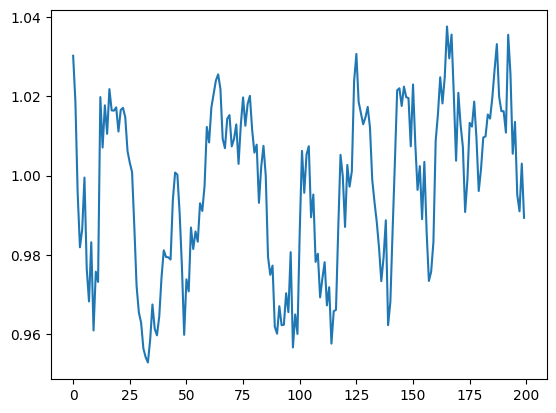

In [47]:
plt.plot(u.detach().numpy().T)